In [ ]:
writer = tf.summary.FileWriter(logdir='tmp/graph_check/1', graph=graph)
writer.flush()

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import ujson as json
import os

In [2]:
tf.reset_default_graph()

In [3]:
saver = tf.train.import_meta_graph('ckpts/trial_folded2/folded2-mr-100-200-20-64-4_epoch_31.meta', clear_devices=True)
# We can now access the default graph where all our metadata has been loaded
graph = tf.get_default_graph()

In [4]:
def listdir_nohidden(path):
    list_files = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            list_files.append(f)
    return list_files

In [5]:
test_folder = '../data/clean-eros/test/'
test_filenames = listdir_nohidden(test_folder)

In [6]:
def only_consider_data(obs, time):
    obs_arr = np.array(obs)
    time_arr = np.array(time)
    return np.stack([obs_arr, time_arr]).T

In [7]:
def generate_test_batch(batch_size, batch_num, last_batch=False):
    g_list = []
    g_len_list = []
    r_list = []
    r_len_list = []
    Y = np.zeros((batch_size, n_out))
    folder_name = test_folder
    if last_batch is False:
        files_for_batch = test_filenames[batch_num*batch_size:(batch_num+1)*batch_size]
        for file_num in range(batch_size):
            with open(folder_name+files_for_batch[file_num]) as data_file:
                output = json.load(data_file)
            g_list.append(only_consider_data(output['data_g'], output['time_g']))
            g_len_list.append(len(output['data_g']))
            r_list.append(only_consider_data(output['data_r'], output['time_r']))
            r_len_list.append(len(output['data_r']))
            Y[file_num, :] = output['class_array']
        # Finding optimal lengths of matrices
        max_g_len = np.max(g_len_list)
        max_r_len = np.max(r_len_list)

        X_g = np.zeros((batch_size, max_g_len, n_input+1))
        X_r = np.zeros((batch_size, max_r_len, n_input+1))

        for i in range(batch_size):
            X_g[i, :g_len_list[i], :] = g_list[i]
            X_r[i, :r_len_list[i], :] = r_list[i]
    else:
        files_for_batch = test_filenames[batch_num*batch_size:]
        for file_num in range(len(files_for_batch)):
            with open(folder_name+files_for_batch[file_num]) as data_file:
                output = json.load(data_file)
            g_list.append(only_consider_data(output['data_g'], output['time_g']))
            g_len_list.append(len(output['data_g']))
            r_list.append(only_consider_data(output['data_r'], output['time_r']))
            r_len_list.append(len(output['data_r']))
            Y[file_num, :] = output['class_array']
        # Finding optimal lengths of matrices
        max_g_len = np.max(g_len_list)
        max_r_len = np.max(r_len_list)
        X_g = np.zeros((batch_size, max_g_len, n_input+1))
        X_r = np.zeros((batch_size, max_r_len, n_input+1))
        num_files_last_batch = len(files_for_batch)
        for i in range(len(files_for_batch)):
            X_g[i, :g_len_list[i], :] = g_list[i]
            X_r[i, :r_len_list[i], :] = r_list[i]
        g_len_list = g_len_list + [0]*(batch_size - num_files_last_batch)
        r_len_list = r_len_list + [0]*(batch_size - num_files_last_batch)
        
    return X_g, X_r, Y, np.array(g_len_list), np.array(r_len_list), files_for_batch

In [9]:
n_hidden = 10
batch_size = 64
n_layers = 2
unit = "PLSTM"
n_out = 3
n_input = 1

In [11]:
num_batches = int((len(test_filenames)/batch_size))+1

In [12]:
 X_g, X_r, Y, len_g, len_r, files_list = generate_test_batch(batch_size, num_batches-1, last_batch=True)

In [13]:
Y

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.

In [16]:
with tf.Session() as sess:
    #Restoring the model
    saver.restore(sess, 'ckpts/trial_folded2/folded2-mr-100-200-20-64-4_epoch_26')
    for i in range(num_batches-4, num_batches):
        if i == num_batches-4:
            X_g, X_r, Y, len_g, len_r, file_list = generate_test_batch(batch_size, i)
            out_concat, accuracy, cost = sess.run(["BiasAdd:0", "Mean_1:0", "Mean:0"], 
                                               feed_dict={"Placeholder:0": X_g,
                                                          "Placeholder_2:0": X_r,
                                                          "Placeholder_1:0": len_g,
                                                          "Placeholder_3:0": len_r,
                                                          "Placeholder_4:0": Y})
            accuracy_net = accuracy
            cost_net = cost
            y_concat = Y
            file_list_net = file_list
        if i == num_batches-1:
            X_g, X_r, Y, len_g, len_r, file_list = generate_test_batch(batch_size, i, last_batch=True)
            
            out, accuracy, cost = sess.run(["BiasAdd:0", "Mean_1:0", "Mean:0"],
                                        feed_dict={"Placeholder:0": X_g,
                                                   "Placeholder_2:0": X_r,
                                                   "Placeholder_1:0": len_g,
                                                   "Placeholder_3:0": len_r,
                                                   "Placeholder_4:0": Y})
            cost_net = (cost_net*i + cost)/(i+1)
            accuracy_net = (accuracy_net*i + accuracy)/(i+1)
            out_concat = np.append(out_concat, out[:len(file_list), :], axis=0)
            y_concat = np.append(y_concat, Y[:len(file_list), :], axis=0)
            file_list_net = file_list_net + file_list
            
        else:
            X_g, X_r, Y, len_g, len_r, file_list = generate_test_batch(batch_size, i)
            out, accuracy, cost = sess.run(["BiasAdd:0", "Mean_1:0", "Mean:0"],
                                        feed_dict={"Placeholder:0": X_g,
                                                   "Placeholder_2:0": X_r,
                                                   "Placeholder_1:0": len_g,
                                                   "Placeholder_3:0": len_r,
                                                   "Placeholder_4:0": Y})
            cost_net = (cost_net*i + cost)/(i+1)
            accuracy_net = (accuracy_net*i + accuracy)/(i+1)
            out_concat = np.append(out_concat, out, axis=0)
            y_concat = np.append(y_concat, Y, axis=0)
            file_list_net = file_list_net + file_list

In [17]:
out_concat.shape

(299, 3)

In [18]:
out_net = np.argmax(out_concat, axis=1)
y_net = np.argmax(y_concat, axis=1)

#### Generating metrics

In [19]:
import sklearn.metrics as metrics


In [21]:
accuracy = metrics.accuracy_score(y_net, out_net)
conf_mat = metrics.confusion_matrix(y_net, out_net)
f1_score = metrics.f1_score(y_net, out_net, average= 'weighted')
recall_score = metrics.recall_score(y_net, out_net, average= 'weighted')
precision_score = metrics.precision_score(y_net, out_net, average= 'weighted')

In [22]:
f1_score

0.98187933668763527

In [23]:
recall_score

0.98327759197324416

In [24]:
precision_score

0.9836683024411591

In [130]:
#Create a dataframe for evaluation results
def create_eval_frame(file_name)
    df = pd.DataFrame()
    df['Label'] = y_net
    df['Predicted'] = out_net
    df['Name'] = file_list_net
    df['Classified'] = df['Label'] == df['Predicted']
    df.to_csv(save_path+file_name+str('.csv'))

In [131]:
metrics_dict = {}
metrics_dict['Accuracy'] = accuracy
metrics_dict['Confusion_Matrix'] = conf_mat.tolist()
metrics_cost['Cost'] = cost_net

Mean_1:0 - Corresponds to the accuracy value
Mean:0 - Corresponds to the cross-entropy loss
BiasAdd:0 - Corresponds to the resulting output

In [25]:
with tf.Session() as sess:
    # To initialize values with saved data
    saver.restore(sess, 'ckpts/trial_folded2/folded2-mr-100-200-20-64-4_epoch_31')
    op = sess.graph.get_operations()

In [26]:
print [m.values() for m in op]

[(<tf.Tensor 'Placeholder:0' shape=(?, ?, 2) dtype=float32>,), (<tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=int32>,), (<tf.Tensor 'Placeholder_2:0' shape=(?, ?, 2) dtype=float32>,), (<tf.Tensor 'Placeholder_3:0' shape=(?,) dtype=int32>,), (<tf.Tensor 'Placeholder_4:0' shape=(?, 3) dtype=float32>,), (<tf.Tensor 'random_normal/shape:0' shape=(2,) dtype=int32>,), (<tf.Tensor 'random_normal/mean:0' shape=() dtype=float32>,), (<tf.Tensor 'random_normal/stddev:0' shape=() dtype=float32>,), (<tf.Tensor 'random_normal/RandomStandardNormal:0' shape=(200, 3) dtype=float32>,), (<tf.Tensor 'random_normal/mul:0' shape=(200, 3) dtype=float32>,), (<tf.Tensor 'random_normal:0' shape=(200, 3) dtype=float32>,), (<tf.Tensor 'Variable:0' shape=(200, 3) dtype=float32_ref>,), (<tf.Tensor 'Variable/Assign:0' shape=(200, 3) dtype=float32_ref>,), (<tf.Tensor 'Variable/read:0' shape=(200, 3) dtype=float32>,), (<tf.Tensor 'random_normal_1/shape:0' shape=(1,) dtype=int32>,), (<tf.Tensor 'random_normal_1/mean:0'

In [82]:
with tf.Session() as sess:
    #Restoring the model
    saver.restore(sess, 'ckpts/trial_folded2/folded2-mr-100-200-20-64-4_epoch_26')
    for i in range(20):
        X_g, X_r, Y, len_g, len_r, files_list = generate_test_batch(batch_size, i)
        if i == 0:
            pre_layer_out_concat, out_concat, accuracy, cost = sess.run(["concat:0", "BiasAdd:0", "Mean_1:0", "Mean:0"],
                               feed_dict={"Placeholder:0": X_g,
                                          "Placeholder_2:0": X_r,
                                          "Placeholder_1:0": len_g,
                                          "Placeholder_3:0": len_r,
                                          "Placeholder_4:0": Y})
            y_concat = Y
        else:
            pre_layer_out, out, accuracy, cost = sess.run(["concat:0", "BiasAdd:0", "Mean_1:0", "Mean:0"],
                               feed_dict={"Placeholder:0": X_g,
                                          "Placeholder_2:0": X_r,
                                          "Placeholder_1:0": len_g,
                                          "Placeholder_3:0": len_r,
                                          "Placeholder_4:0": Y})
            out_concat = np.append(out_concat, out, axis=0)
            y_concat = np.append(y_concat, Y, axis=0)
            pre_layer_out_concat = np.append(pre_layer_out_concat, pre_layer_out, axis=0)

In [83]:
out_b = np.argmax(out_concat, axis=1)
y_b = np.argmax(y_concat, axis=1)

In [84]:
np.sum(out_b == y_b)/float(len(out_b))

0.96875

In [85]:
pre_layer_out_concat.shape

(1280, 200)

In [86]:
from sklearn.cluster import KMeans

In [87]:
kmeans_obj = KMeans(n_clusters=3)

In [88]:
clusters_out = kmeans_obj.fit_predict(pre_layer_out_concat)

In [89]:
clusters_out.tolist().count(0), clusters_out.tolist().count(1), clusters_out.tolist().count(2)

(123, 820, 337)

In [90]:
out_b.tolist().count(0), out_b.tolist().count(1), out_b.tolist().count(2)

(762, 387, 131)

In [91]:
y_b.tolist().count(0), y_b.tolist().count(1), y_b.tolist().count(2)

(743, 388, 149)

In [92]:
metrics.confusion_matrix(y_b, out_b)

array([[740,   3,   0],
       [  9, 374,   5],
       [ 13,  10, 126]])

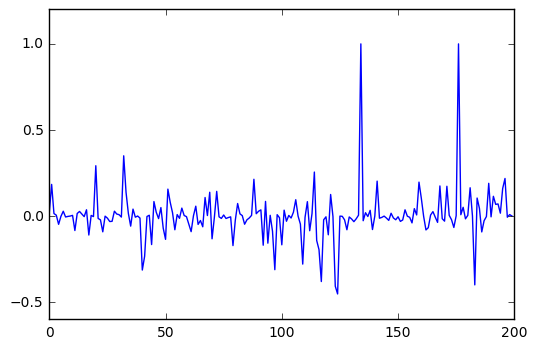

In [37]:
plt.plot(pre_layer_out[16,:])

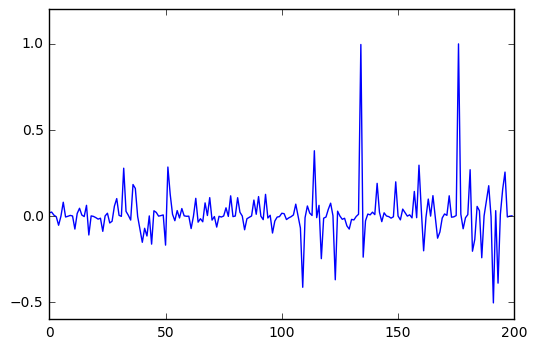

In [38]:
plt.plot(pre_layer_out[13,:])

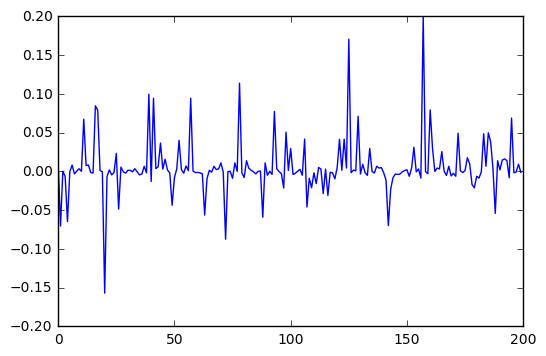

In [46]:
plt.plot(pre_layer_out[22,:])

In [ ]:
plt.plot(pre_layer_out[13,:])

In [45]:
y_b[22], out_b[22]

(2, 0)

#### Generating class weights

In [146]:
class_labels = []
for file_num in range(len(train_filenames)):
    with open(train_folder+train_filenames[file_num]) as data_file:
        output = json.load(data_file)
    class_labels.append(output['class_value'])
counts_0 = class_labels.count(0)
counts_1 = class_labels.count(1)
counts_2 = class_labels.count(2)
weight_class2 = counts_0/float(counts_2*len(class_labels))
weight_class1 = 1./float(len(class_labels))
weight_class0 = counts_2/float(counts_0*len(class_labels))
sample_weights = []
for i in class_labels:
    if i == 0:
        sample_weights.append(weight_class0)
    elif i == 1:
        sample_weights.append(weight_class1)
    else:
        sample_weights.append(weight_class2)

In [145]:
sample_weights[:10], class_labels[:10]

([2.3218417375892996e-05,
  2.3218417375892996e-05,
  0.0008431790784052673,
  2.3218417375892996e-05,
  0.32461172519938436,
  2.3218417375892996e-05,
  2.3218417375892996e-05,
  0.0008431790784052673,
  2.3218417375892996e-05,
  2.3218417375892996e-05],
 [0, 0, 2, 0, 1, 0, 0, 2, 0, 0])

In [134]:
len(class_labels)

7147

In [138]:
class_labels.count(0), class_labels.count(1), class_labels.count(2)

(4140, 2320, 687)

Cluster the data for the regression in order to look for the classes. t-SNE is a great idea for clustering as well. This illustrates to a good extent what the PLSTM is doing with the data in order for it to classify the types correctly.

In [100]:
tf.reset_default_graph()

In [101]:
saver = tf.train.import_meta_graph('ckpts/wtrial_folded6/wfolded6-mr-100-100-20-64-4_epoch_51.meta', clear_devices=True)
# We can now access the default graph where all our metadata has been loaded
graph = tf.get_default_graph()

In [102]:
with tf.Session() as sess:
    # To initialize values with saved data
    saver.restore(sess, 'ckpts/wtrial_folded6/wfolded6-mr-100-100-20-64-4_epoch_51')
    op = sess.graph.get_operations()

In [103]:
print [m.name for m in op]

[u'x_g', u'len_g', u'x_r', u'len_r', u'y', u'random_normal/shape', u'random_normal/mean', u'random_normal/stddev', u'random_normal/RandomStandardNormal', u'random_normal/mul', u'random_normal', u'Variable', u'Variable/Assign', u'Variable/read', u'random_normal_1/shape', u'random_normal_1/mean', u'random_normal_1/stddev', u'random_normal_1/RandomStandardNormal', u'random_normal_1/mul', u'random_normal_1', u'Variable_1', u'Variable_1/Assign', u'Variable_1/read', u'g/zeros', u'g/zeros_1', u'g/zeros_2', u'g/zeros_3', u'g/zeros_4', u'g/zeros_5', u'g/zeros_6', u'g/zeros_7', u'g/Slice/begin', u'g/Slice/size', u'g/Slice', u'g/Slice_1/begin', u'g/Slice_1/size', u'g/Slice_1', u'g/concat/concat_dim', u'g/concat', u'g/0/transpose/perm', u'g/0/transpose', u'g/0/sequence_length', u'g/0/RNN/Shape', u'g/0/RNN/strided_slice/stack', u'g/0/RNN/strided_slice/stack_1', u'g/0/RNN/strided_slice/stack_2', u'g/0/RNN/strided_slice', u'g/0/RNN/strided_slice_1/stack', u'g/0/RNN/strided_slice_1/stack_1', u'g/0/RNN

In [111]:
with tf.Session() as sess:
    #Restoring the model
    saver.restore(sess, 'ckpts/wtrial_folded6/wfolded6-mr-100-100-20-64-4_epoch_97')
    for i in range(4):
        X_g, X_r, Y, len_g, len_r, files_list = generate_test_batch(batch_size, i)
        if i == 0:
            pre_layer_out_concat, out_concat, accuracy, cost = sess.run(["concat:0", 
                                                                         "pred_unscaled:0",
                                                                         "accuracy:0",
                                                                         "cost:0"],
                               feed_dict={"x_g:0": X_g,
                                          "x_r:0": X_r,
                                          "len_g:0": len_g,
                                          "len_r:0": len_r,
                                          "y:0": Y})
            y_concat = Y
        else:
            pre_layer_out, out, accuracy, cost = sess.run(["concat:0", 
                                                           "pred_unscaled:0",
                                                           "accuracy:0",
                                                           "cost:0"],
                               feed_dict={"x_g:0": X_g,
                                          "x_r:0": X_r,
                                          "len_g:0": len_g,
                                          "len_r:0": len_r,
                                          "y:0": Y})
            out_concat = np.append(out_concat, out, axis=0)
            y_concat = np.append(y_concat, Y, axis=0)
            pre_layer_out_concat = np.append(pre_layer_out_concat, pre_layer_out, axis=0)

In [112]:
out_b = np.argmax(out_concat, axis=1)
y_b = np.argmax(y_concat, axis=1)
np.sum(out_b == y_b)/float(len(out_b))

0.95703125